# PRINCIPAL COMPONENT ANALYSIS

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Parameters" data-toc-modified-id="1-Parameters-1">1 Parameters</a></span></li><li><span><a href="#2-Import" data-toc-modified-id="2-Import-2">2 Import</a></span><ul class="toc-item"><li><span><a href="#2.1-Packages" data-toc-modified-id="2.1-Packages-2.1">2.1 Packages</a></span></li><li><span><a href="#2.2-Files" data-toc-modified-id="2.2-Files-2.2">2.2 Files</a></span></li></ul></li><li><span><a href="#3-Covariance-Matrix" data-toc-modified-id="3-Covariance-Matrix-3">3 Covariance Matrix</a></span></li><li><span><a href="#4-Eigen-Decomposition" data-toc-modified-id="4-Eigen-Decomposition-4">4 Eigen Decomposition</a></span></li><li><span><a href="#5-Transformation" data-toc-modified-id="5-Transformation-5">5 Transformation</a></span></li><li><span><a href="#6-Inverse-Transformation" data-toc-modified-id="6-Inverse-Transformation-6">6 Inverse Transformation</a></span></li><li><span><a href="#7-Error-Metrics" data-toc-modified-id="7-Error-Metrics-7">7 Error Metrics</a></span></li><li><span><a href="#8-Visualization" data-toc-modified-id="8-Visualization-8">8 Visualization</a></span><ul class="toc-item"><li><span><a href="#8.1-PC-Loadings" data-toc-modified-id="8.1-PC-Loadings-8.1">8.1 PC Loadings</a></span></li><li><span><a href="#8.2-PC-Scores" data-toc-modified-id="8.2-PC-Scores-8.2">8.2 PC Scores</a></span></li><li><span><a href="#8.3-Goodness-of-Fit" data-toc-modified-id="8.3-Goodness-of-Fit-8.3">8.3 Goodness of Fit</a></span></li><li><span><a href="#8.4-Correlation" data-toc-modified-id="8.4-Correlation-8.4">8.4 Correlation</a></span></li></ul></li><li><span><a href="#9-Extraction" data-toc-modified-id="9-Extraction-9">9 Extraction</a></span></li></ul></div>

### 1 Parameters
***

In [1]:
freq_all = ["day","week"]
freq = freq_all[0]

k = 3
pred_start = "2020-06-30"

In [2]:
# Print settings
print (f'- Yield curve frequency is {freq}-wise.')
print (f'- PCA will make use of {k} main components.')
print (f'- PC-loadings and scores will be determined up to {pred_start}')

- Yield curve frequency is day-wise.
- PCA will make use of 3 main components.
- PC-loadings and scores will be determined up to 2020-06-30


### 2 Import
***

#### 2.1 Packages

In [3]:
# Data handling
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:,.6f}'.format

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.pyplot import cm
import seaborn as sns
%config InlineBackend.figure_format ="retina"

# Date formats
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

# Other
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 2.2 Files

In [4]:
# Cleaned spot data
filepath_in   = "../assets/files/02-clean/"
filename_spot = "spot_"+str(freq)+".csv"
filename_tenors = "tenors.csv"

spot = pd.read_csv(filepath_in + filename_spot, index_col = 0)
spot.columns.name = "spot_"+str(freq)
spot.index = pd.to_datetime(spot.index)

In [5]:
# List of used tenors
tenors_df = pd.read_csv(filepath_in+filename_tenors, index_col = 0)
tenors_str = tenors_df["MAT_STR"]
tenors_num = tenors_df["MAT_NUM"]

instances = spot.shape[0]

In [6]:
spot = spot[spot.index < pred_start]
spot.tail()

spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2019-12-19,-0.682263,-0.678758,-0.670892,-0.645761,-0.604714,-0.549918,-0.486016,-0.417653,-0.348567,-0.281409,...,-0.055515,0.029057,0.097659,0.153431,0.199154,0.237061,0.268872,0.295887,0.319085,0.339208
2019-12-20,-0.664610,-0.665012,-0.663800,-0.648287,-0.613333,-0.562300,-0.500637,-0.433528,-0.365068,-0.298142,...,-0.071621,0.013484,0.082578,0.138777,0.184862,0.223074,0.255144,0.282379,0.305766,0.326054
2019-12-23,-0.688774,-0.685967,-0.679865,-0.658826,-0.621619,-0.569904,-0.508232,-0.441336,-0.373106,-0.306344,...,-0.079716,0.005687,0.075110,0.131623,0.177989,0.216447,0.248728,0.276146,0.299692,0.320119
2019-12-27,-0.685799,-0.685163,-0.679331,-0.652514,-0.610504,-0.558202,-0.499445,-0.437205,-0.373758,-0.310814,...,-0.084262,0.007214,0.083015,0.144071,0.191934,0.228394,0.255253,0.274198,0.286737,0.294176
2019-12-30,-0.683520,-0.676921,-0.660710,-0.618394,-0.566399,-0.508163,-0.446377,-0.383121,-0.319983,-0.258151,...,-0.037668,0.052156,0.127907,0.190515,0.241356,0.281964,0.313868,0.338497,0.357136,0.370901


<img src="../assets/img/data-matrix.PNG">

### 3 Covariance Matrix
***

- Import clean yield data
- Calculate covariance matrix in <code>cov_matrix</code>
- Calculate correlation matrix in <code>corr_matrix</code>

In [7]:
# Covariance Matrix
cov_data = np.array(spot).T

cov_matrix = np.cov(cov_data, bias = True)
cov_matrix = pd.DataFrame(data = cov_matrix)
cov_matrix = pd.DataFrame(data = cov_matrix.values, 
                          columns = list(tenors_str), 
                          index = list(tenors_str))

# Correlation Matrix
corr_matrix = pd.DataFrame(data = (spot[spot.index < pred_start]).corr().values,
                           columns = list(tenors_str), 
                           index = list(tenors_str))

cov_matrix.columns.name = "COV"
corr_matrix.columns.name = "CORR"

In [8]:
print ("Covariance matrix: XT * X")
print (f'- Row: Features f = {cov_matrix.shape[0]}')
print (f'- Col: Features f = {cov_matrix.shape[1]}')

corr_matrix

Covariance matrix: XT * X
- Row: Features f = 22
- Col: Features f = 22


CORR,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
3M,1.000000,0.999105,0.995717,0.982541,0.964585,0.944560,0.924103,0.904209,0.885482,0.868297,...,0.817945,0.803701,0.795609,0.792471,0.793109,0.796474,0.801688,0.808051,0.815024,0.822204
6M,0.999105,1.000000,0.998006,0.985845,0.968354,0.948516,0.928070,0.908077,0.889186,0.871802,...,0.820633,0.806065,0.797724,0.794411,0.794935,0.798236,0.803427,0.809798,0.816802,0.824030
1Y,0.995717,0.998006,1.000000,0.993784,0.979897,0.962459,0.943704,0.924933,0.906933,0.890196,...,0.840192,0.825749,0.817387,0.813959,0.814306,0.817383,0.822311,0.828386,0.835067,0.841950
2Y,0.982541,0.985845,0.993784,1.000000,0.995681,0.985508,0.972367,0.957988,0.943447,0.929440,...,0.885567,0.872395,0.864604,0.861258,0.861335,0.863881,0.868083,0.873282,0.878972,0.884778
3Y,0.964585,0.968354,0.979897,0.995681,1.000000,0.996933,0.989561,0.979860,0.969110,0.958169,...,0.921494,0.909917,0.902905,0.899764,0.899641,0.901697,0.905199,0.909548,0.914280,0.919054
4Y,0.944560,0.948516,0.962459,0.985508,0.996933,1.000000,0.997779,0.992365,0.985165,0.977145,...,0.947530,0.937575,0.931384,0.928499,0.928231,0.929862,0.932740,0.936329,0.940208,0.944068
5Y,0.924103,0.928070,0.943704,0.972367,0.989561,0.997779,1.000000,0.998364,0.994348,0.988987,...,0.965975,0.957589,0.952217,0.949614,0.949247,0.950511,0.952837,0.955747,0.958863,0.961909
6Y,0.904209,0.908077,0.924933,0.957988,0.979860,0.992365,0.998364,1.000000,0.998784,0.995796,...,0.978822,0.971918,0.967340,0.965031,0.964601,0.965549,0.967385,0.969684,0.972113,0.974425
7Y,0.885482,0.889186,0.906933,0.943447,0.969110,0.985165,0.994348,0.998784,1.000000,0.999096,...,0.987556,0.982028,0.978205,0.976193,0.975727,0.976404,0.977803,0.979555,0.981364,0.983012
8Y,0.868297,0.871802,0.890196,0.929440,0.958169,0.977145,0.988987,0.995796,0.999096,1.000000,...,0.993279,0.989006,0.985887,0.984165,0.983687,0.984133,0.985148,0.986411,0.987663,0.988715


### 4 Eigen Decomposition
***

- Performing eigen-decomposition of covariance matrix on <code>eig</code>
- Store list with number of pc's for labeling in <code>pc_index</code>
- Extract eigen value explainability ratio in <code>omega_df</code>
- Extract eigen vector loadings in <code>W</code> and reduce them to k components in <code>W_k</code>

<img src="../assets/img/pc-loadings.PNG">

In [9]:
eig = np.linalg.eig(cov_matrix)

pc_index = list(["PC_"+str(i) for i in range(1, eig[0].shape[0]+1)])

# Eigenvalues 
omega = pd.DataFrame(eig[0].real, columns = ["EIG_VAL"], index = pc_index)
omega["EIG_VAL_REL"] = omega["EIG_VAL"].apply(lambda x: x/omega["EIG_VAL"].sum())
omega["EIG_VAL_CUM"] = omega["EIG_VAL_REL"].cumsum()


# Eigenvectors
W = pd.DataFrame(eig[1].real, index = list(tenors_str), columns = pc_index)
W_k = W.iloc[:,:k]
W.columns.name = "W"
W_k.columns.name = "W_k"

In [10]:
print ("Eigen values: Lambda")
print (f'- Row: Explained variance pc = {omega.shape[0]}')
print (f'- Col: One-dimension scalar = {omega.shape[1]}')

omega.head()

Eigen values: Lambda
- Row: Explained variance pc = 22
- Col: One-dimension scalar = 3


,EIG_VAL,EIG_VAL_REL,EIG_VAL_CUM
PC_1,49.467182,0.946894,0.946894
PC_2,2.607882,0.049920,0.996814
PC_3,0.133960,0.002564,0.999378
PC_4,0.018713,0.000358,0.999736
PC_5,0.009964,0.000191,0.999927


In [11]:
print ("Eigen vector loadings: W")
print (f'- Row: Features f = {W.shape[0]}')
print (f'- Col: Principal components pc = {W.shape[1]}')

W.head()

Eigen vector loadings: W
- Row: Features f = 22
- Col: Principal components pc = 22


W,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22
3M,-0.196372,0.402376,-0.410651,0.266521,-0.282373,-0.580958,0.342136,-0.114775,-0.096655,0.049772,...,0.002454,0.001002,-0.000301,-0.000039,-0.000004,-0.000014,-0.000020,0.000029,0.000027,0.000001
6M,-0.201648,0.411771,-0.329023,0.189601,-0.128267,0.274507,-0.546754,0.366635,0.288906,-0.173106,...,-0.009775,-0.004034,0.001242,0.000173,0.000015,0.000060,0.000087,-0.000126,-0.000119,-0.000005
1Y,-0.209201,0.392183,-0.146365,-0.047934,0.216361,0.526711,0.044499,-0.427894,-0.389915,0.299587,...,0.024267,0.010606,-0.003499,-0.000545,-0.000042,-0.000177,-0.000268,0.000398,0.000378,0.000027
2Y,-0.218944,0.311363,0.113101,-0.260877,0.382617,0.061923,0.431564,-0.026321,0.288545,-0.438926,...,-0.096270,-0.050421,0.019885,0.004023,0.000151,0.001101,0.001895,-0.002946,-0.002863,-0.000398
3Y,-0.224191,0.227208,0.244706,-0.247132,0.231533,-0.198309,0.044340,0.347532,0.186042,0.206387,...,0.289363,0.197154,-0.098505,-0.026774,0.000682,-0.006024,-0.012049,0.019713,0.020101,0.004429


In [12]:
print ("Selected eigen vector loadings: W_k")
print (f'- Row: Features f = {W_k.shape[0]}')
print (f'- Col: Principal components selected k = {W_k.shape[1]}')

W_k.head()

Selected eigen vector loadings: W_k
- Row: Features f = 22
- Col: Principal components selected k = 3


W_k,PC_1,PC_2,PC_3
3M,-0.196372,0.402376,-0.410651
6M,-0.201648,0.411771,-0.329023
1Y,-0.209201,0.392183,-0.146365
2Y,-0.218944,0.311363,0.113101
3Y,-0.224191,0.227208,0.244706


### 5 Transformation
***

- Multiply principals component loadings <code>W</code> with yield data <code>spot</code> in <code>T</code>
- Keep only k components in <code>T_k</code> in order to reduce dimensions

<img src="../assets/img/pc-transform.PNG">

In [13]:
T = np.matrix(spot) * np.matrix(W)
T = pd.DataFrame(data = T, 
                 index = pd.to_datetime(spot.index), 
                 columns = pc_index)


T_k = T.iloc[:,:k]
T.columns.name = "T"
T_k.columns.name = "T_k"

In [14]:
print ("Eigen vectors transformed: T_k")
print (f'- Row: Observations n = {T_k.shape[0]}')
print (f'- Col: Principal components selected k = {T_k.shape[1]}')

T_k.head()

Eigen vectors transformed: T_k
- Row: Observations n = 3832
- Col: Principal components selected k = 3


T_k,PC_1,PC_2,PC_3
2005-01-03,-16.328820,-3.668907,-1.486289
2005-01-04,-16.316495,-3.641159,-1.350717
2005-01-05,-16.419910,-3.646035,-1.325228
2005-01-06,-16.196140,-3.634970,-1.370522
2005-01-07,-16.061056,-3.613224,-1.377357


### 6 Inverse Transformation
***

- Get inverse matrix of principal component loadings in <code>W_inv</code>
- Keep only k transformed principal component loadings <code>W_k_inv</code>
- Multiply <code>T_k</code> with <code>W_k_inv</code> to receive PCA dimensionality reduced yields in <code>X_k</code>

<img src="../assets/img/pc-reverse-transform.PNG">

In [15]:
W_inv = pd.DataFrame (data = np.linalg.inv(np.matrix(W)),
                      columns = list(tenors_str),
                      index = pc_index)

W_inv.columns.name = "W_inv"

W_k_inv = W_inv.copy()
W_k_inv = W_k_inv.iloc[:k,:]
W_k_inv.columns.name = "W_k_inv"

In [16]:
print ("Inverse of all eigen vector loadings: W_inv")
print (f'- Row: Principal components pc = {W_inv.shape[0]}')
print (f'- Col: Features f = {W_inv.shape[1]}')

W_inv.head()

Inverse of all eigen vector loadings: W_inv
- Row: Principal components pc = 22
- Col: Features f = 22


W_inv,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
PC_1,-0.196372,-0.201648,-0.209201,-0.218944,-0.224191,-0.226494,-0.226933,-0.226245,-0.224918,-0.223263,...,-0.216270,-0.213266,-0.210681,-0.208461,-0.206540,-0.204859,-0.203367,-0.202024,-0.200800,-0.199671
PC_2,0.402376,0.411771,0.392183,0.311363,0.227208,0.151637,0.086154,0.030243,-0.017058,-0.056747,...,-0.156470,-0.180464,-0.192829,-0.196672,-0.194398,-0.187842,-0.178380,-0.167032,-0.154542,-0.141450
PC_3,-0.410651,-0.329023,-0.146365,0.113101,0.244706,0.299416,0.307798,0.288153,0.252204,0.207713,...,0.024347,-0.046852,-0.100134,-0.137243,-0.161082,-0.174707,-0.180870,-0.181855,-0.179451,-0.175006
PC_4,0.266521,0.189601,-0.047934,-0.260877,-0.247132,-0.162784,-0.064588,0.027652,0.106702,0.170011,...,0.268188,0.241876,0.182852,0.103286,0.012888,-0.081255,-0.174361,-0.263454,-0.346877,-0.423885
PC_5,-0.282373,-0.128267,0.216361,0.382617,0.231533,0.041168,-0.105523,-0.190823,-0.219487,-0.203740,...,0.053255,0.177150,0.252765,0.272714,0.240251,0.163543,0.052253,-0.084278,-0.237876,-0.401820


In [17]:
print ("Inverse of selected eigen vector loadings: W_k_inv")
print (f'- Row: Principal components selected k = {W_k_inv.shape[0]}')
print (f'- Col: Features_f = {W_k_inv.shape[1]}')

W_k_inv.head()

Inverse of selected eigen vector loadings: W_k_inv
- Row: Principal components selected k = 3
- Col: Features_f = 22


W_k_inv,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
PC_1,-0.196372,-0.201648,-0.209201,-0.218944,-0.224191,-0.226494,-0.226933,-0.226245,-0.224918,-0.223263,...,-0.216270,-0.213266,-0.210681,-0.208461,-0.206540,-0.204859,-0.203367,-0.202024,-0.200800,-0.199671
PC_2,0.402376,0.411771,0.392183,0.311363,0.227208,0.151637,0.086154,0.030243,-0.017058,-0.056747,...,-0.156470,-0.180464,-0.192829,-0.196672,-0.194398,-0.187842,-0.178380,-0.167032,-0.154542,-0.141450
PC_3,-0.410651,-0.329023,-0.146365,0.113101,0.244706,0.299416,0.307798,0.288153,0.252204,0.207713,...,0.024347,-0.046852,-0.100134,-0.137243,-0.161082,-0.174707,-0.180870,-0.181855,-0.179451,-0.175006


In [18]:
X_k = np.matrix(T_k) * np.matrix(W_k_inv)
X_k = pd.DataFrame(data = X_k, 
                   columns = list(tenors_str),
                   index = spot.index)

X_k.columns.name = "X_k"

In [19]:
print ("Back-transformed from PC scores to yields in original dimensionalty: X_k")
print (f'- Row: Observations n = {X_k.shape[0]}')
print (f'- Col: Features f = {X_k.shape[1]}')

X_k.head()

Back-transformed from PC scores to yields in original dimensionalty: X_k
- Row: Observations n = 3832
- Col: Features f = 22


X_k,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2005-01-03,2.340584,2.270954,2.194659,2.264641,2.463472,2.697012,2.931981,3.155084,3.360374,3.545096,...,4.069314,4.214133,4.296472,4.329469,4.325197,4.293939,4.244021,4.181923,4.112541,4.039472
2005-01-04,2.293656,2.235288,2.183120,2.285916,2.500189,2.739021,2.973304,3.192200,3.391321,3.568930,...,4.065607,4.200145,4.274950,4.302837,4.295419,4.262517,4.212043,4.150144,4.081449,4.009360
2005-01-05,2.301535,2.245748,2.199111,2.309923,2.528503,2.769336,3.004198,3.222794,3.421092,3.597590,...,4.089356,4.221885,4.295125,4.321855,4.313620,4.280165,4.229334,4.167215,4.098394,4.026238
2005-01-06,2.280645,2.220084,2.163267,2.259252,2.469766,2.706769,2.940429,3.159450,3.359150,3.537594,...,4.038127,4.174288,4.250383,4.279248,4.272548,4.240159,4.190045,4.128397,4.059880,3.987920
2005-01-07,2.265675,2.204047,2.144536,2.235674,2.442749,2.677425,2.909543,3.127576,3.326673,3.504782,...,4.005344,4.141875,4.218414,4.247750,4.241521,4.209595,4.159931,4.098717,4.030621,3.959067


### 7 Error Metrics
***

In [20]:
# RMSE 
se = (X_k - spot)**2
rmse = pd.DataFrame(data = se.T.mean(), columns = ["RMSE"])**0.5
rmse.index = pd.to_datetime(rmse.index)

# MAE
ae = abs(X_k - spot)
mae = pd.DataFrame(data = ae.T.mean(), columns = ["MAE"])
mae.index = pd.to_datetime(mae.index)

In [21]:
# Group RMSE per year
rmse_year = se.copy()
rmse_year["year"] = rmse_year.index.year
rmse_year = rmse_year.groupby("year").mean()**0.5

rmse_year.index.name = None
rmse_year.columns.name = "sq_err"
rmse_year.iloc[:5,:5]

sq_err,3M,6M,1Y,2Y,3Y
2005,0.182944,0.088406,0.050591,0.130374,0.117753
2006,0.246525,0.078647,0.111910,0.179043,0.126225
2007,0.165822,0.069020,0.067810,0.126911,0.095941
2008,0.154458,0.104073,0.071621,0.128346,0.095223
2009,0.164575,0.123748,0.043913,0.163989,0.157897


In [22]:
rmse.mean()

RMSE   0.115295
dtype: float64

In [23]:
mae.mean()

MAE   0.096636
dtype: float64

### 8 Visualization
***

#### 8.1 PC Loadings

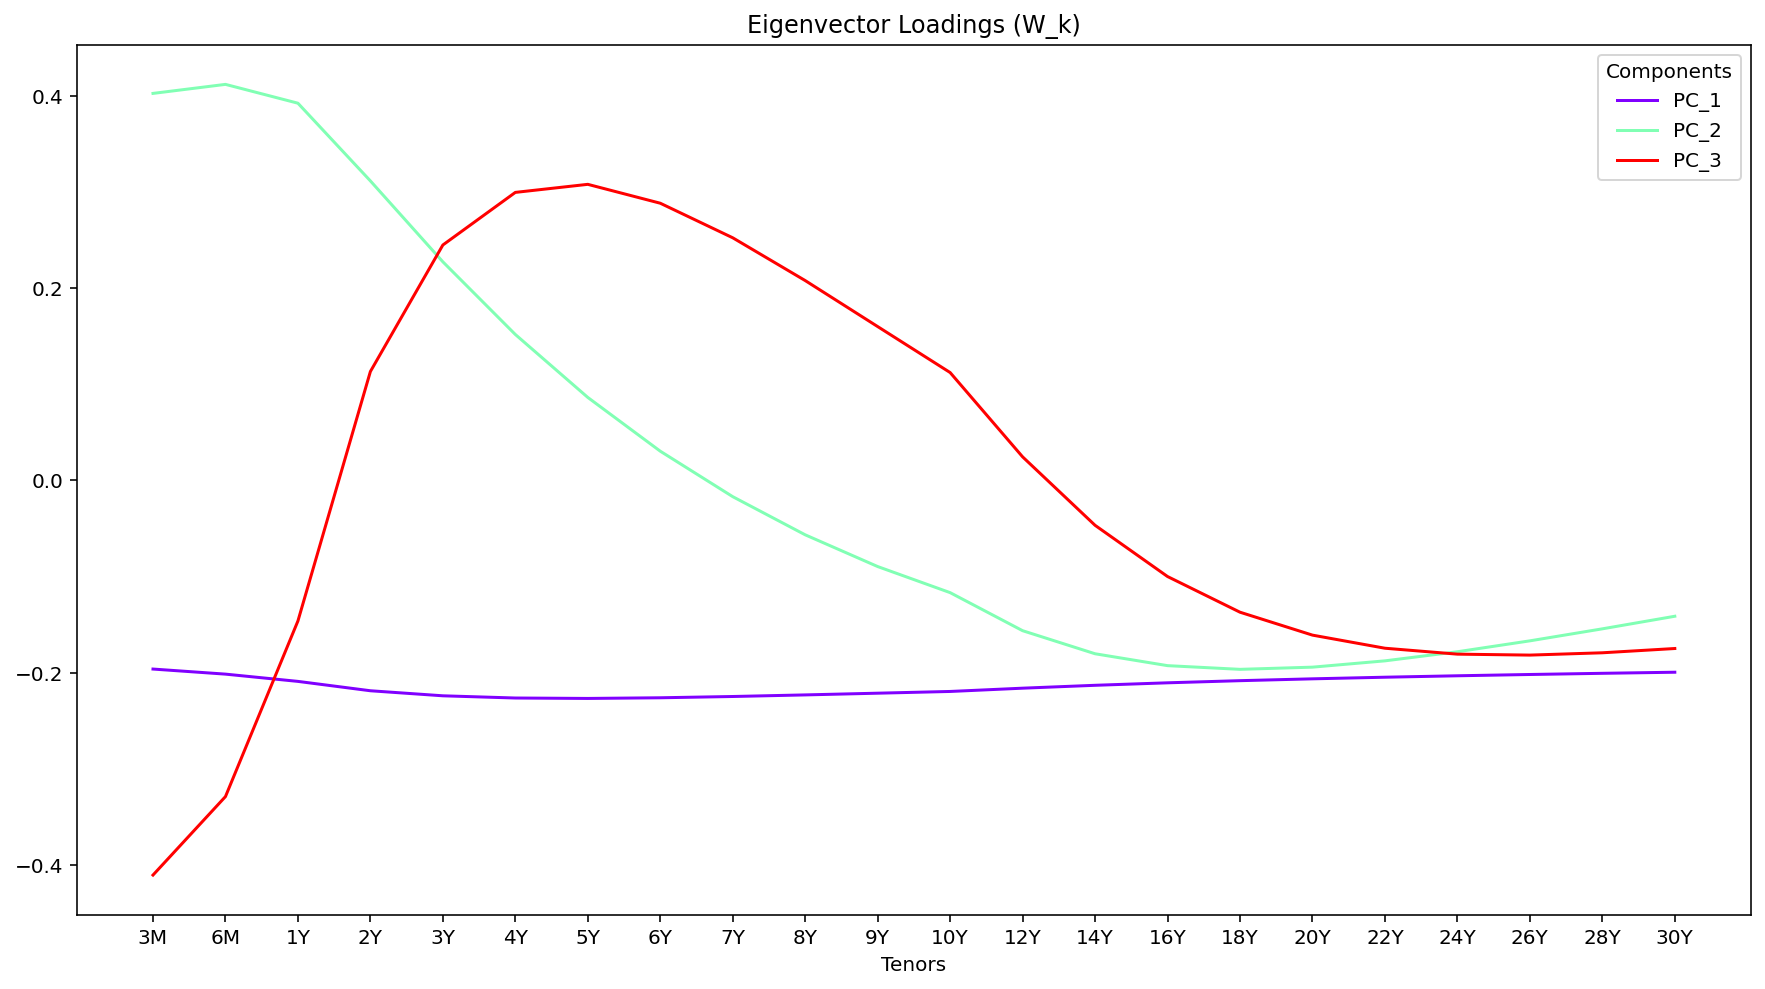

In [24]:
color = cm.rainbow(np.linspace(0,1,3))
pcs = ["PC_1","PC_2","PC_3"]

fig_1 = plt.figure(figsize = [15,8])

for i,c in zip(pcs, color):
    plt.plot(W_k[i],c = c, label = i)

plt.title ("Eigenvector Loadings (W_k)")
plt.xlabel ("Tenors")
plt.legend(title = "Components")

plt.show()

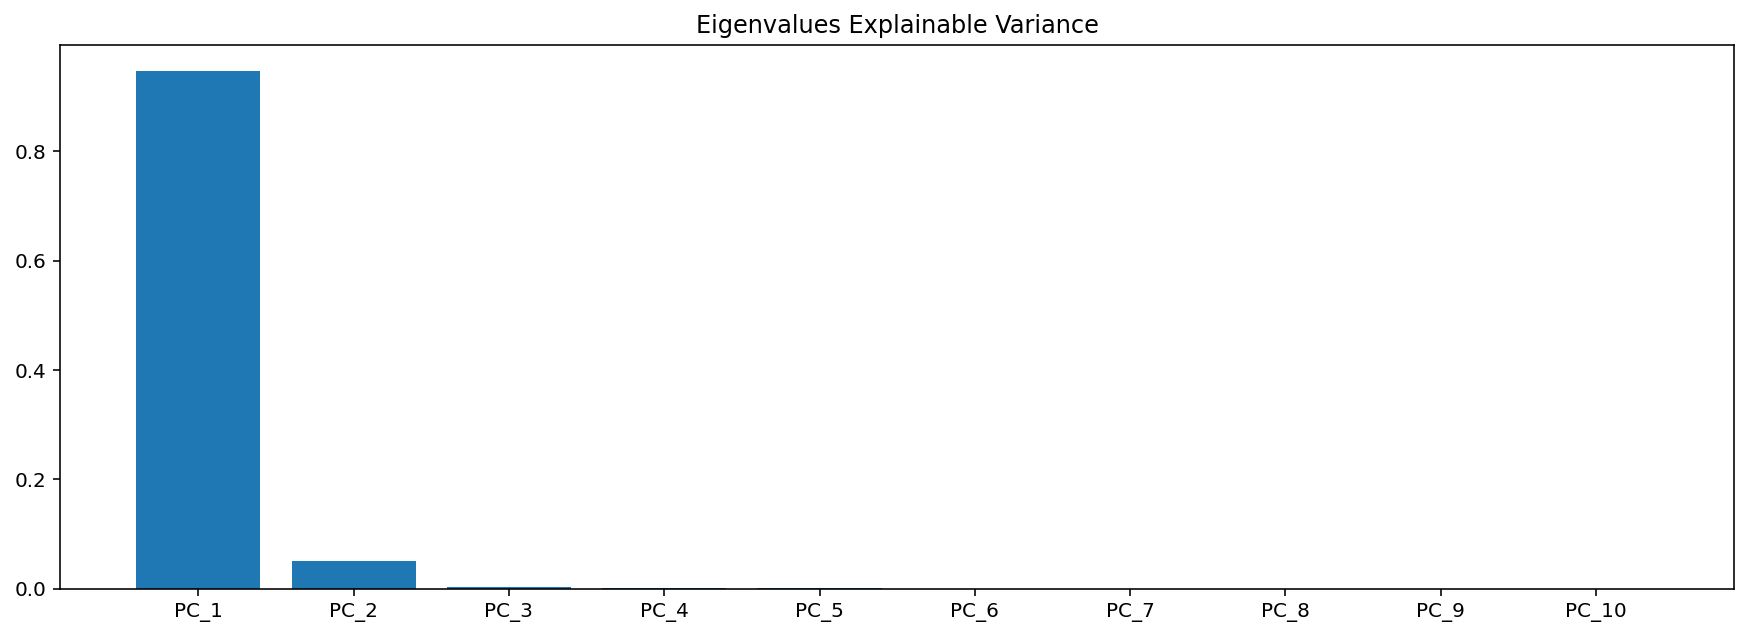

In [25]:
fig_2 = plt.figure(figsize = [15,5])

plt.bar(omega.index[:10], omega["EIG_VAL_REL"][:10])
plt.title ("Eigenvalues Explainable Variance")
plt.show()

#### 8.2 PC Scores

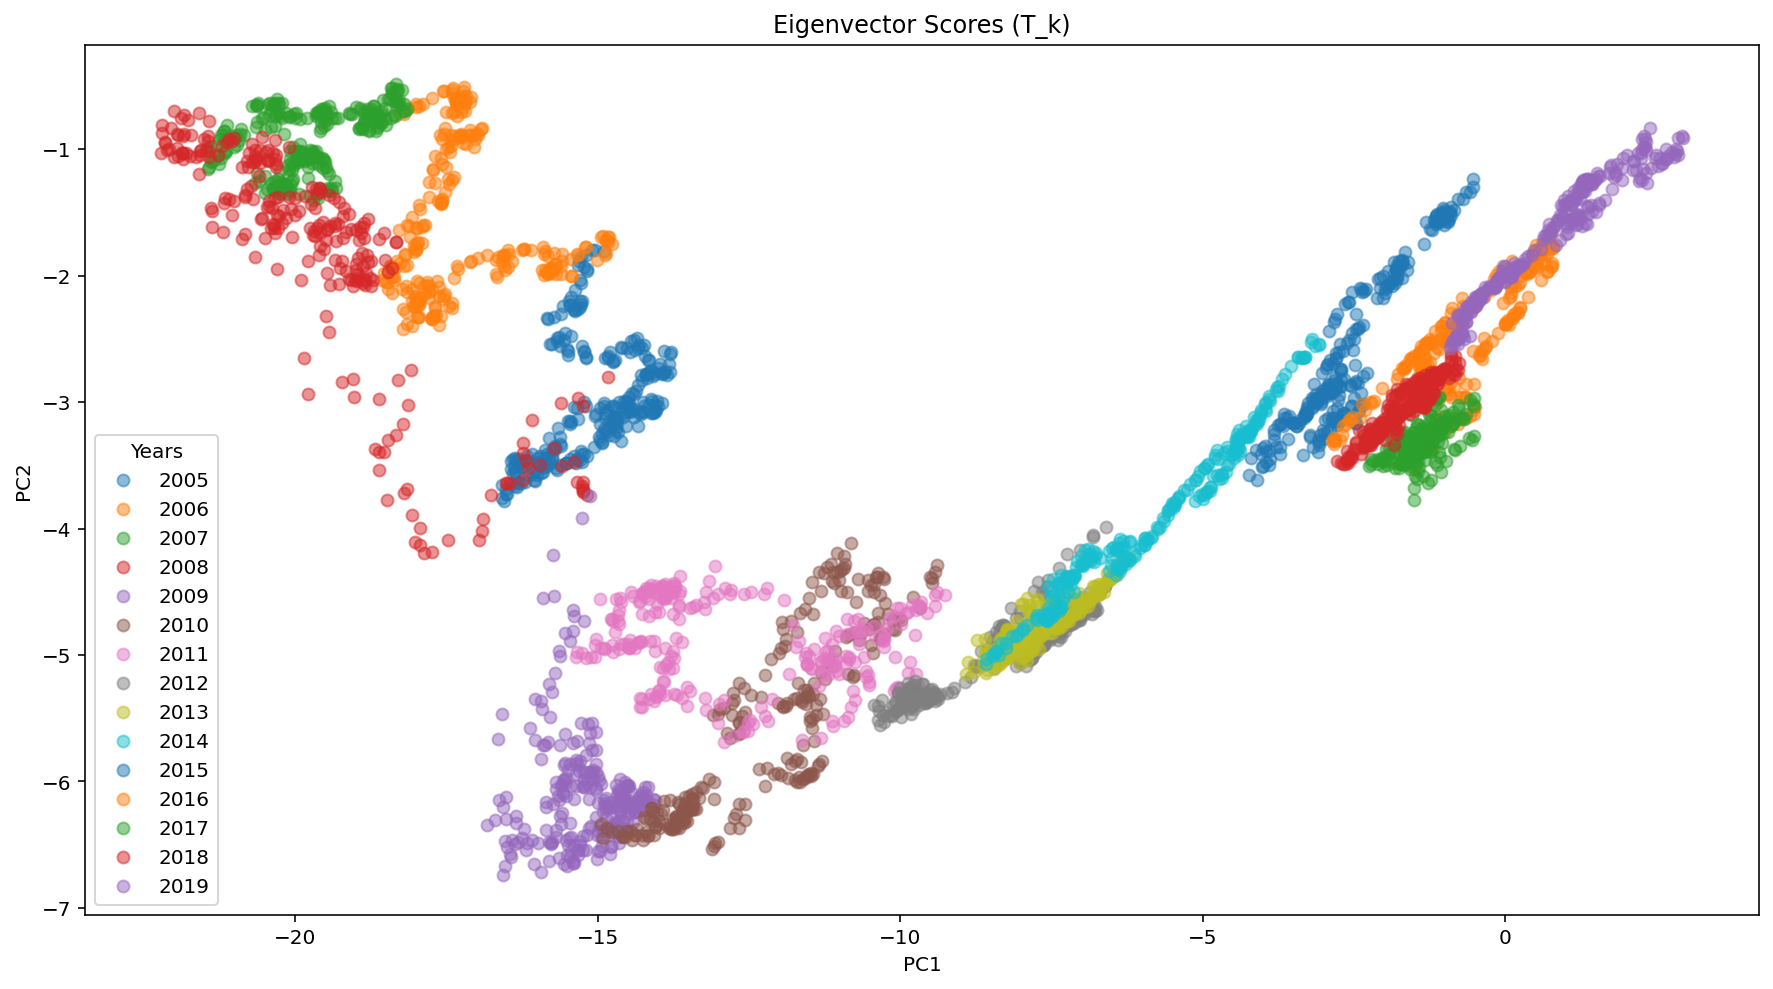

In [26]:
# Prepare data for visualization
T_k_viz = T_k.copy()
T_k_viz["Year"] = pd.DatetimeIndex(T_k_viz.index).year
T_k_viz = T_k_viz.groupby("Year")


# Create chart
fig_2 = plt.figure(figsize = [15,8])

for label, group in T_k_viz:
    plt.plot(group["PC_1"], 
             group["PC_2"], 
             marker = "o", 
             linestyle = "",
             alpha = 0.5,
             label=label)


# Format chart
plt.title ("Eigenvector Scores (T_k)")
plt.xlabel ("PC1")
plt.ylabel ("PC2")
plt.legend(title = "Years")

plt.show()

In [27]:
scaler = StandardScaler()

pc_1 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))*-1
pc_2 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))*-1
pc_3 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))

lvl_factor = scaler.fit_transform(spot["10Y"].values.reshape(-1, 1))
slope_factor = scaler.fit_transform((spot["10Y"] - spot["6M"]).values.reshape(-1, 1))
curve_factor = scaler.fit_transform((spot["6M"] + spot["10Y"] - 2*spot["5Y"]).values.reshape(-1, 1))

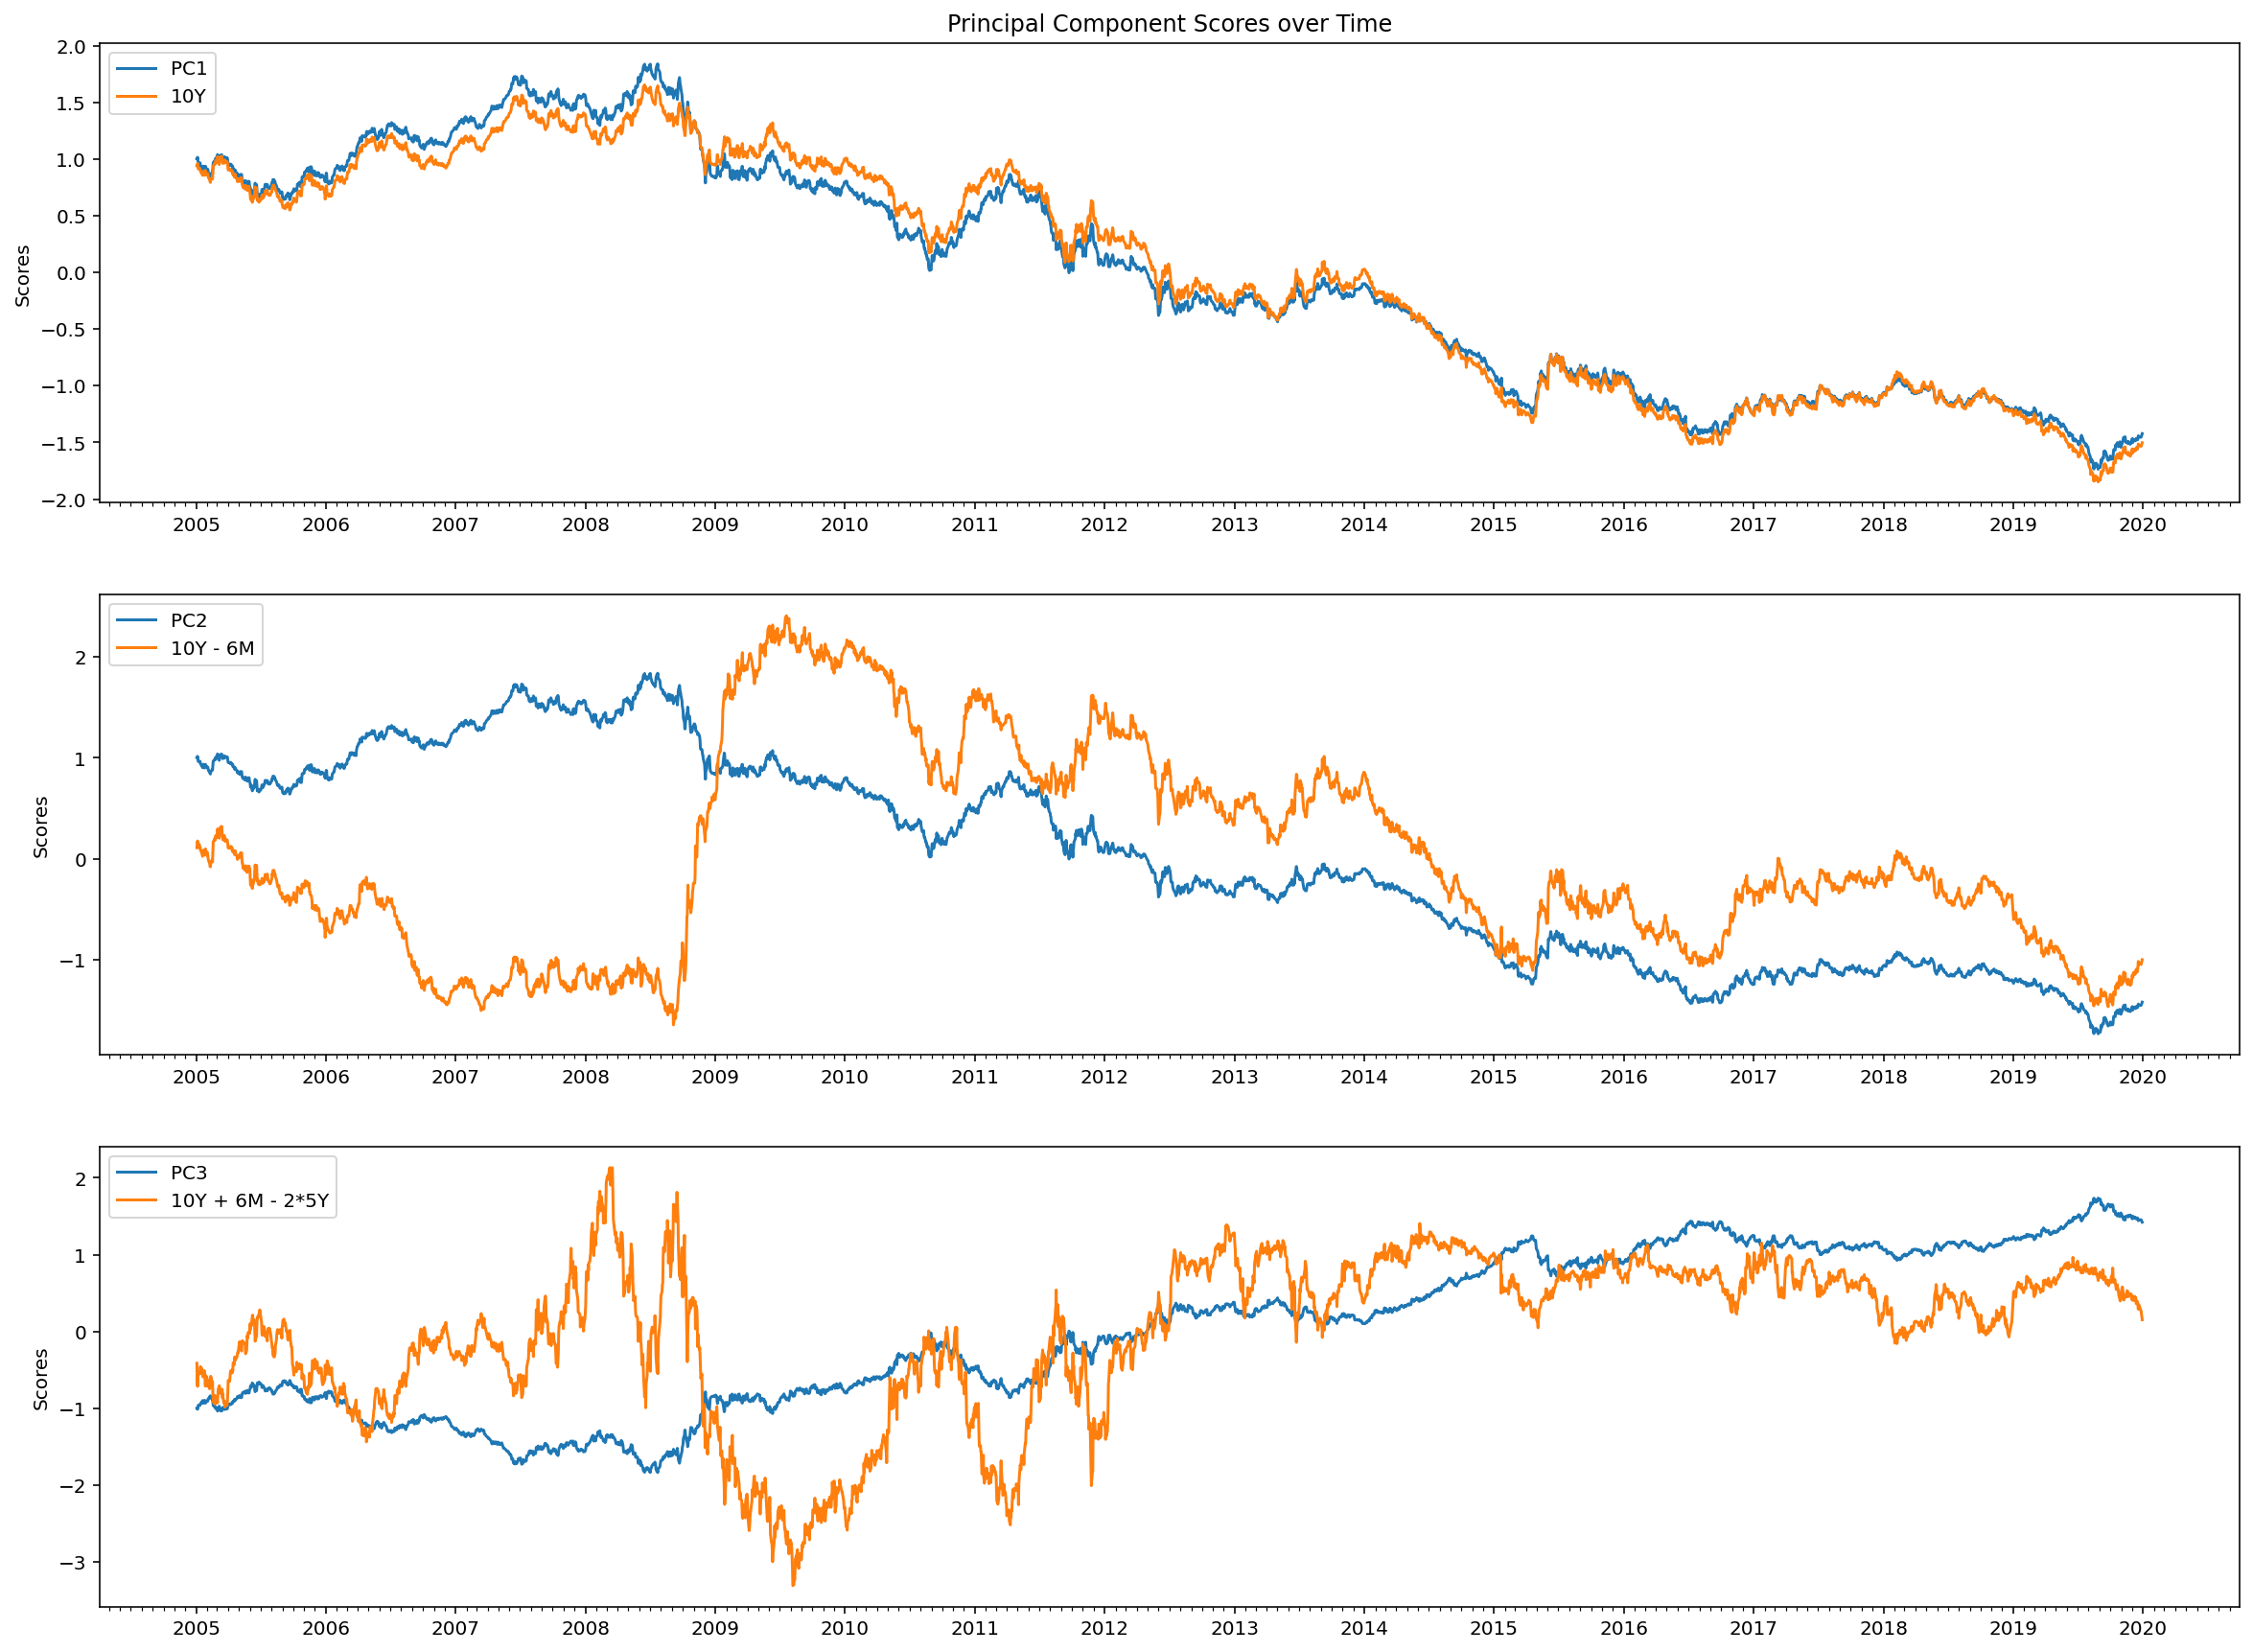

In [28]:
fig, ax = plt.subplots(3, 1, figsize = (20,15))

# Plots ---------------------------------------------------------------------------
ax[0].plot(T_k.index, pc_1, label = "PC1")
ax[0].plot(T_k.index, lvl_factor, label = "10Y")

ax[1].plot(T_k.index, pc_2, label = "PC2")
ax[1].plot(T_k.index, slope_factor, label = "10Y - 6M")

ax[2].plot(T_k.index, pc_3, label = "PC3")
ax[2].plot(T_k.index, curve_factor, label = "10Y + 6M - 2*5Y")


# Format chart --------------------------------------------------------------------
ax[0].set_title ("Principal Component Scores over Time")

for i in range (3):
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years)
    ax[i].xaxis.set_minor_locator(months)
    
    ax[i].set_ylabel ("Scores")
    ax[i].legend(loc = "upper left")

plt.show()

#### 8.3 Goodness of Fit

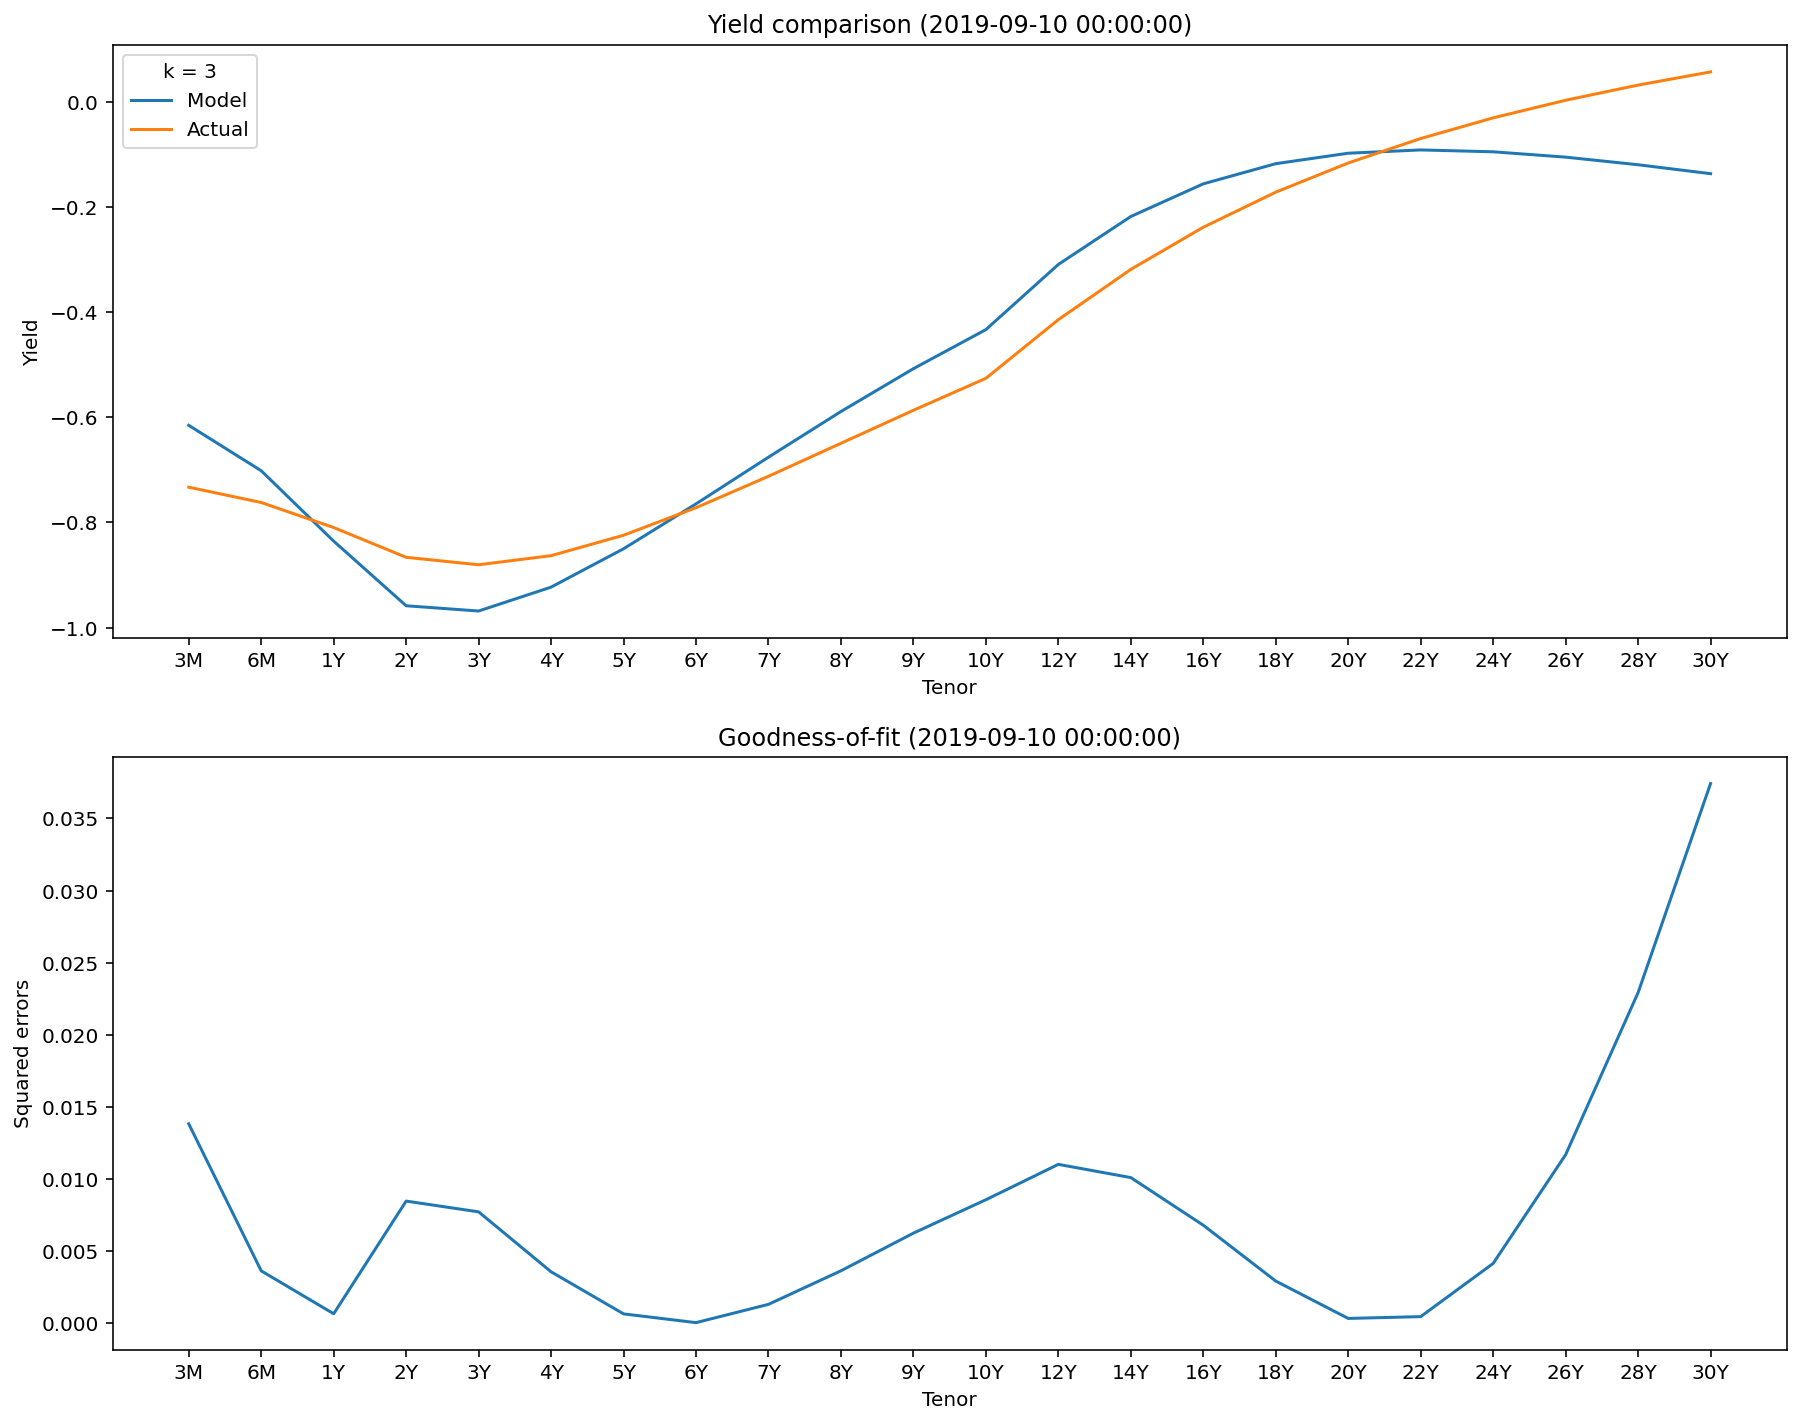

In [29]:
chart_date = spot.index[round(instances*0.98)]

fig_3, ax = plt.subplots(2, 1, figsize = (15,12))

ax[0].plot(X_k.loc[chart_date,:], label ="Model")
ax[0].plot(spot.loc[chart_date,:], label = "Actual")
ax[1].plot(se.loc[chart_date,:])

ax[0].set_xlabel("Tenor")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield comparison ({chart_date})")

ax[1].set_xlabel("Tenor")
ax[1].set_ylabel("Squared errors")
ax[1].set_title(f"Goodness-of-fit ({chart_date})")

ax[0].legend(title = "k = "+str(k))
plt.show()

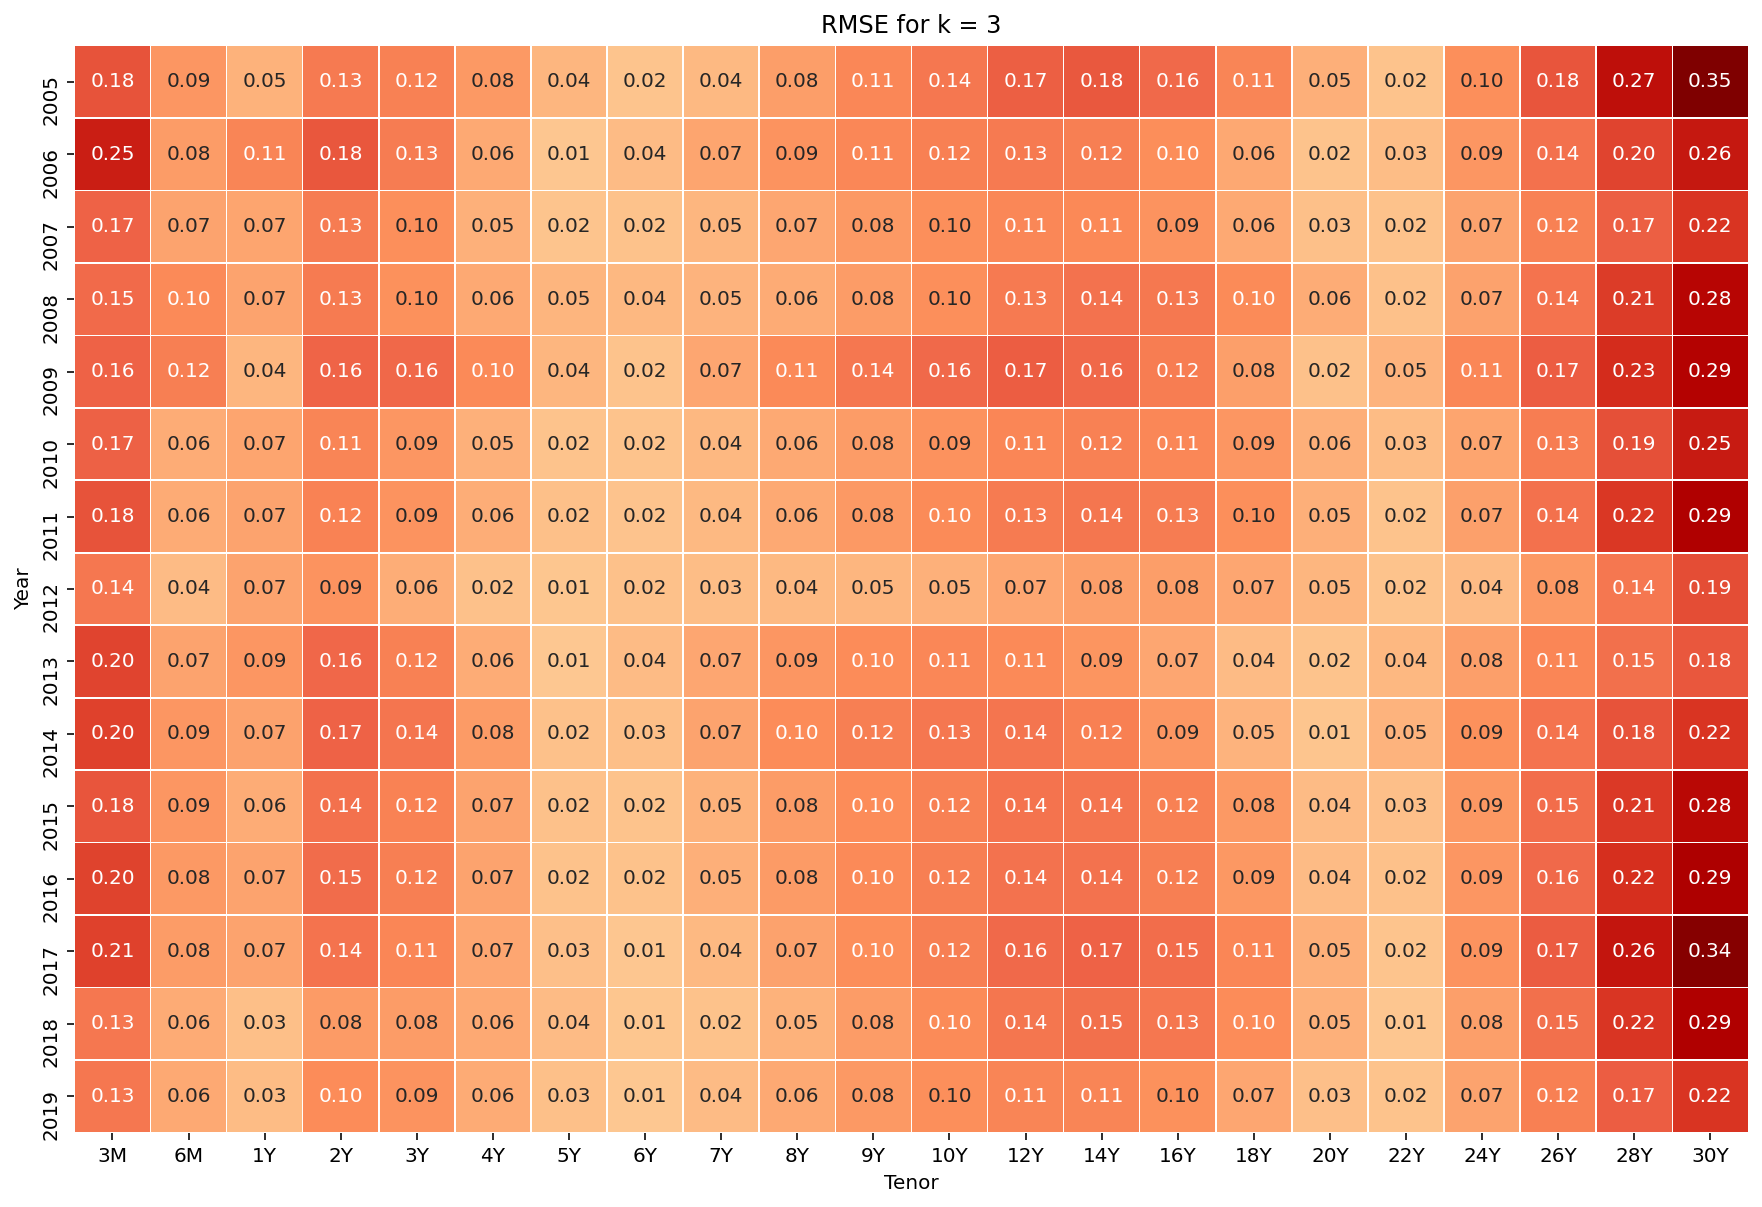

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(rmse_year, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("RMSE for k = "+str(k))
ax.set(xlabel="Tenor", ylabel="Year")
plt.show()

No handles with labels found to put in legend.


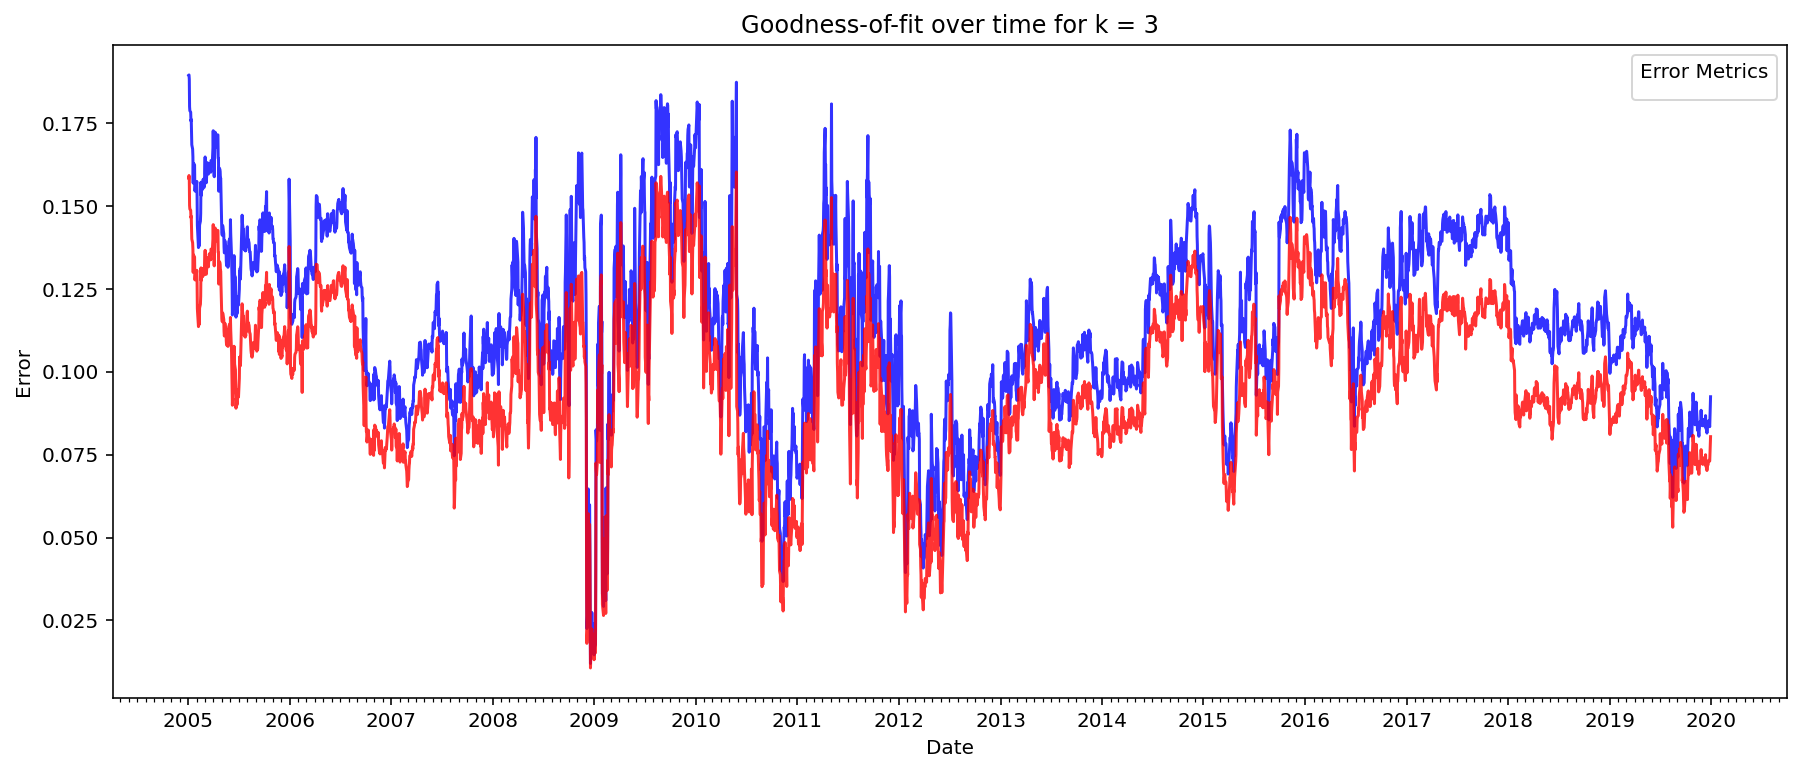

In [31]:
fig_5, ax = plt.subplots(1, 1, figsize = (15,6))

# Plots
ax.plot (rmse.iloc[:,0], c="blue", alpha = 0.8)
ax.plot (mae.iloc[:,0], c="red", alpha = 0.8)

# Format chart
ax.set_title ("Goodness-of-fit over time for k = "+ str(k))
ax.set_xlabel ("Date")
ax.set_ylabel ("Error")

# Format ticks
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.legend(title = "Error Metrics")

plt.show()

#### 8.4 Correlation

In [32]:
pc_corr = pd.concat([spot, T_k], axis = 1)
pc_corr = pc_corr.corr()
pc_corr = pc_corr.iloc[:,-k:]
pc_corr

,PC_1,PC_2,PC_3
3M,-0.899889,0.423377,-0.097929
6M,-0.902515,0.423156,-0.076633
1Y,-0.917772,0.395044,-0.033415
2Y,-0.949772,0.310126,0.025532
3Y,-0.972158,0.226218,0.055219
4Y,-0.985978,0.151566,0.067829
5Y,-0.993706,0.086620,0.070138
6Y,-0.997261,0.030608,0.066097
7Y,-0.998012,-0.017379,0.058236
8Y,-0.996938,-0.058181,0.048266


### 9 Extraction
***

In [33]:
filepath_out = "../assets/files/03-pca/"

W_k_inv.to_csv(filepath_out+"W_k_inv_" + str(freq)+".csv")
W_k.to_csv(filepath_out+"W_k_" + str(freq)+".csv")
T_k.to_csv(filepath_out+"T_k_" + str(freq)+".csv")
X_k.to_csv(filepath_out+"X_k_" + str(freq)+".csv")